# Querying Scalar Quantities and Annually Averaged Timeseries

Models compute globally averaged quantities that are stored in `ocean_scalars.nc` files. This notebook shows how we do data discovery on scalar quantities and plot them as time series.

**Requirements:** The `conda/analysis3-20.01` (or later) module on the VDI (or your own up-to-date cookbook installation).

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import pandas as pd
import matplotlib.pyplot as plt
from dask.distributed import Client

It's often a good idea to start a cluster with multiple cores for you to work with. 

In [2]:
client = Client(n_workers=4)
client

2023-02-06 11:49:45,236 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/71575849.gadi-pbs/dask-worker-space/worker-sdfjql07', purging
2023-02-06 11:49:45,236 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/71575849.gadi-pbs/dask-worker-space/worker-zh4ww9_f', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 50.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45363,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 50.00 GiB
Comm: tcp://127.0.0.1:43581,Total threads: 1
Dashboard: /proxy/41001/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:44071,


### Querying Scalar Quantities
Connect to the default database:

In [3]:
session = cc.database.create_session()

An **experiment** is a particular model run with a given forcing.  It composed of several independed runs of the mode code.

Here is a list experiments that are based on the 0.25 degree and are based on the JRA55v13 forcing with at least 2000 NetCDF files. 

In [4]:
df = cc.querying.get_experiments(session)
# df[df['experiment'].str.contains("025deg_jra55v13") & (df.ncfiles > 500)]
df[df['experiment'].str.contains("025deg_jra55_iaf_omip2_cycle") & (df.ncfiles >1000)]

,experiment,ncfiles
41,025deg_jra55_iaf_omip2_cycle5,2171
95,025deg_jra55_iaf_omip2_cycle1,2171
120,025deg_jra55_iaf_omip2_cycle3,2210
121,025deg_jra55_iaf_omip2_cycle2,2171
122,025deg_jra55_iaf_omip2_cycle6,2171
123,025deg_jra55_iaf_omip2_cycle4,2171
167,025deg_jra55_iaf_omip2_cycle6_ext,1570
168,025deg_jra55_iaf_omip2_cycle6_14to17,3042
169,025deg_jra55_iaf_omip2_cycle6_78to08,5860


An experiment is composed of many different **variables** which are stored at different **frequencies**.

The function `cc.querying.get_frequencies` gives a list of the frequencies are available for a particular experiment.

In [5]:
cc.querying.get_frequencies(session, "025deg_jra55v13_iaf_gmredi6")

,frequency
0,None
1,1 daily
2,1 monthly
3,1 yearly
4,static


Here are all of the variables that are stored at the frequency of `1 monthly` and also are files of the form `ocean/ocean_scalar.nc`.

In [6]:
pd.set_option("display.max_rows", 200) # to ensure all rows of the pandas DataFrame are displayed
df = cc.querying.get_variables(session, "025deg_jra55v13_iaf_gmredi6", 
                               frequency = "1 monthly")
df[df.ncfile.str.contains("ocean_scalar.nc")]

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
20,average_DT,Length of average period,days,1 monthly,output153/ocean/ocean_scalar.nc,None,308,1957-12-30 00:00:00,2257-12-30 00:00:00
21,average_T1,Start time for average period,days since 0001-01-01 00:00:00,1 monthly,output153/ocean/ocean_scalar.nc,None,308,1957-12-30 00:00:00,2257-12-30 00:00:00
22,average_T2,End time for average period,days since 0001-01-01 00:00:00,1 monthly,output153/ocean/ocean_scalar.nc,None,308,1957-12-30 00:00:00,2257-12-30 00:00:00
36,eta_global,global ave eta_t plus patm_t/(g*rho0),meter,1 monthly,output153/ocean/ocean_scalar.nc,time: mean,154,1957-12-30 00:00:00,2257-12-30 00:00:00
64,ke_tot,Globally integrated ocean kinetic energy,10^15 Joules,1 monthly,output153/ocean/ocean_scalar.nc,time: mean,154,1957-12-30 00:00:00,2257-12-30 00:00:00
75,nv,vertex number,none,1 monthly,output153/ocean/ocean_scalar.nc,None,308,1957-12-30 00:00:00,2257-12-30 00:00:00
77,pe_tot,Globally integrated ocean potential energy,10^15 Joules,1 monthly,output153/ocean/ocean_scalar.nc,time: mean,154,1957-12-30 00:00:00,2257-12-30 00:00:00
81,rhoave,global mean ocean in-situ density from ocean_d...,kg/m^3,1 monthly,output153/ocean/ocean_scalar.nc,time: mean,154,1957-12-30 00:00:00,2257-12-30 00:00:00
85,salt_global_ave,Global mean salt in liquid seawater,psu,1 monthly,output153/ocean/ocean_scalar.nc,time: mean,154,1957-12-30 00:00:00,2257-12-30 00:00:00
86,salt_surface_ave,Global mass weighted mean surface salt in liqu...,psu,1 monthly,output153/ocean/ocean_scalar.nc,time: mean,154,1957-12-30 00:00:00,2257-12-30 00:00:00


Say, we want to look at one of these variables such as "total_ocean_salt".  We use `cc.querying.getvar()` for this.

In [7]:
experiment = "025deg_jra55_iaf_omip2_cycle5"
variable = "total_ocean_salt"
da = cc.querying.getvar(experiment, variable, session,ncfile='ocean_scalar.nc')
da

<xarray.DataArray 'total_ocean_salt' (time: 732, scalar_axis: 1)>
dask.array<concatenate, shape=(732, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) datetime64[ns] 1958-01-14T12:00:00 ... 2018-12-14T12:...
Attributes:
    long_name:      total mass of salt in liquid seawater
    units:          kg/1e18
    valid_range:    [-1.e+02  1.e+10]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    ncfiles:        ['/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_om...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...

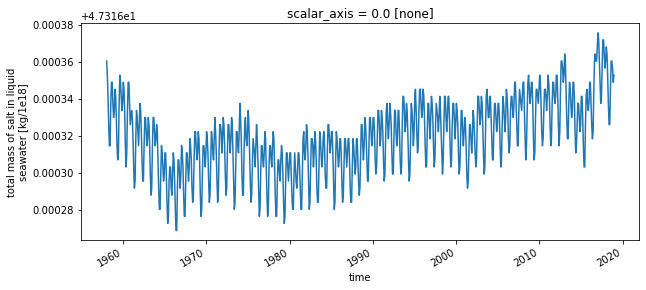

In [8]:
da.plot(figsize=(10,4))

Suppose we want to compare this variable across several different experiments. Using our list of experiments from above, we call put that into a Python list.

In [9]:
df = cc.querying.get_experiments(session)
experiments = list(df[df['experiment'].str.contains("025deg_jra55_iaf_omip2_cycle") & \
   (df.ncfiles > 1000)].experiment)
experiments

['025deg_jra55_iaf_omip2_cycle5',
 '025deg_jra55_iaf_omip2_cycle1',
 '025deg_jra55_iaf_omip2_cycle3',
 '025deg_jra55_iaf_omip2_cycle2',
 '025deg_jra55_iaf_omip2_cycle6',
 '025deg_jra55_iaf_omip2_cycle4',
 '025deg_jra55_iaf_omip2_cycle6_ext',
 '025deg_jra55_iaf_omip2_cycle6_14to17',
 '025deg_jra55_iaf_omip2_cycle6_78to08']

And for each experiment, extract out the variable of interest and store the result in a dictionary using the experiment as the key. Notice we are computing the variables and storing the results for later visualization.

Here we add an exception for experiments that do not have total_ocean_salt as an output

In [10]:
results = dict()
for a,experiment in enumerate(experiments):
    variable = "total_ocean_salt"
    try:
        results[experiment] = cc.querying.getvar(experiment, variable, session,ncfile='ocean_scalar.nc').compute()
    except:
        experiments.pop(experiments.index(experiment))
        print("No %s in %s"%(variable, experiment))

Now, plot the results

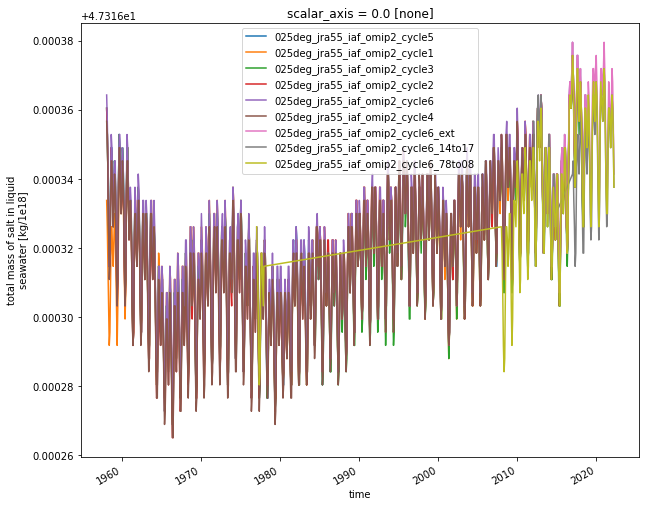

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for experiment in experiments:
    da = results[experiment]
    da.plot(label=experiment, ax=ax)
ax.legend()

### Annually Averaged Scalar Timeseries
This section presents how the data are resampled onto annual averages.

Note that the previous timeseries are monthly so we need to use groupby and a time mean to resample the data onto annual frequency.

In [12]:
results_annual_average = dict()
for experiment in experiments:
    da = results[experiment]
    results_annual_average[experiment] = da.groupby('time.year').mean(dim='time')

**Then,** the data can be plotted as you see fit:

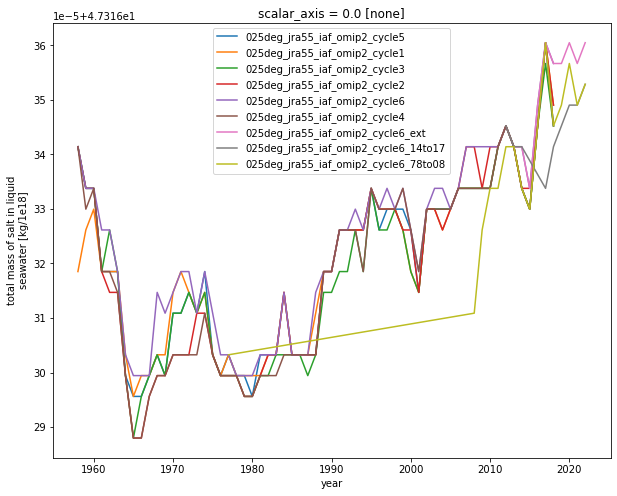

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for experiment in experiments:
    results_annual_average[experiment].plot(label = experiment)
ax.legend()